In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Settings
IMAGE_SIZE = (256, 256)   # Recommended for U-Net
DATA_DIR = r"/kaggle/input/brain-tumor-segmentation"
IMG_DIR = os.path.join(DATA_DIR, "images")
MASK_DIR = os.path.join(DATA_DIR, "masks")


In [3]:
def load_data(img_dir, mask_dir, img_size):
    images = []
    masks = []
    
    for img_name in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)  # same name
        
        if not os.path.exists(mask_path):
            continue
        
        # Load image (grayscale)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size)
        img = img / 255.0
        img = np.expand_dims(img, axis=-1)
        
        # Load mask (binary)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=-1)
        
        images.append(img)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

X, y = load_data(IMG_DIR, MASK_DIR, IMAGE_SIZE)
print("Data Loaded:", X.shape, y.shape)

Data Loaded: (3064, 256, 256, 1) (3064, 256, 256, 1)


In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = Conv2D(1, 1, activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

model = build_unet((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1764082891.274997      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=5,               # Stop after 5 epochs of no improvement
    restore_best_weights=True # Use the best model weights
)

In [7]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=8,
    callbacks=[early_stop]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)
I0000 00:00:1764082907.026305     107 service.cc:148] XLA service 0x795b9c002420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764082907.026919     107 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764082907.966595     107 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764082928.301430     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


306/307 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9702 - loss: 0.2223

E0000 00:00:1764082991.235824     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764082991.490287     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9702 - loss: 0.2219

E0000 00:00:1764083014.818610     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764083015.051274     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764083015.609583     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764083015.864971     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


307/307 ━━━━━━━━━━━━━━━━━━━━ 118s 297ms/step - accuracy: 0.9703 - loss: 0.2215 - val_accuracy: 0.9819 - val_loss: 0.0658
Epoch 2/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 66s 216ms/step - accuracy: 0.9828 - loss: 0.0608 - val_accuracy: 0.9819 - val_loss: 0.0560
Epoch 3/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 66s 216ms/step - accuracy: 0.9836 - loss: 0.0513 - val_accuracy: 0.9848 - val_loss: 0.0446
Epoch 4/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 66s 216ms/step - accuracy: 0.9859 - loss: 0.0416 - val_accuracy: 0.9856 - val_loss: 0.0399
Epoch 5/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 66s 216ms/step - accuracy: 0.9873 - loss: 0.0363 - val_accuracy: 0.9865 - val_loss: 0.0343
Epoch 6/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 66s 216ms/step - accuracy: 0.9892 - loss: 0.0289 - val_accuracy: 0.9890 - val_loss: 0.0294
Epoch 7/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 66s 216ms/step - accuracy: 0.9905 - loss: 0.0250 - val_accuracy: 0.9897 - val_loss: 0.0263
Epoch 8/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 66s 215ms/step - accuracy: 0.9911 - loss: 0.0225 - va

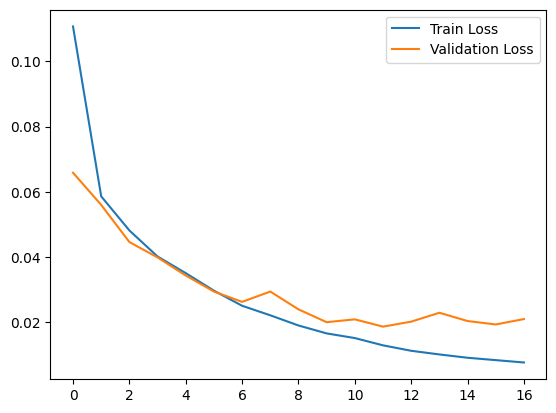

In [8]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(); plt.show()


In [9]:
model.save("segmentation_unet_model.keras")

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

def predict_segmentation_mask(model, image_path, target_size=(256, 256)):
    """
    Predict segmentation mask for U-Net and overlay purple mask.
    """

    # 1. Load & preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    orig_resized = cv2.resize(image, target_size)
    img_norm = orig_resized / 255.0
    img_input = np.expand_dims(img_norm, axis=(0, -1))

    # 2. Predict mask
    pred_mask = model.predict(img_input)[0]  # shape: (H, W, 1)

    # 3. Convert to binary mask
    binary_mask = (pred_mask > 0.5).astype(np.uint8)

    # 4. Prepare overlay in purple color (BGR: 128, 0, 128)
    purple_layer = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
    purple_layer[..., 0] = 128  # Blue
    purple_layer[..., 1] = 0    # Green
    purple_layer[..., 2] = 128  # Red

    # 5. Apply mask to purple layer
    purple_mask = (binary_mask * purple_layer).astype(np.uint8)

    # 6. Convert original grayscale to 3-channel
    gray_3ch = cv2.cvtColor(orig_resized, cv2.COLOR_GRAY2BGR)

    # 7. Blend images
    overlay = cv2.addWeighted(gray_3ch, 0.7, purple_mask, 0.3, 0)

    return orig_resized, (binary_mask * 255).squeeze().astype(np.uint8), overlay


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(256, 256) (256, 256) (256, 256, 3)


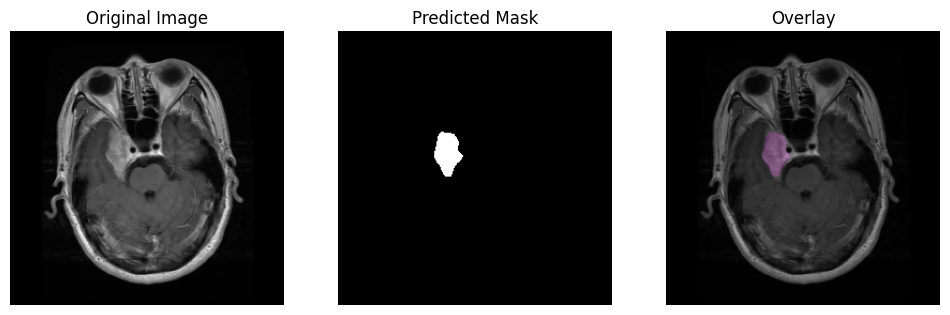

In [11]:
original, mask, overlay = predict_segmentation_mask(
    model,
    r"/kaggle/input/brain-tumor-segmentation/images/100.png"
)

print(original.shape, mask.shape, overlay.shape)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(original, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Predicted Mask")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [20]:
from IPython.display import FileLink
FileLink(r"/kaggle/working/segmentation_unet_model.keras")


/kaggle/working/segmentation_unet_model.keras

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optional optimizations (strongly recommended)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()


INFO:tensorflow:Assets written to: /tmp/tmpawxvn699/assets


INFO:tensorflow:Assets written to: /tmp/tmpawxvn699/assets


Saved artifact at '/tmp/tmpawxvn699'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='keras_tensor_32')
Output Type:
  TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None)
Captures:
  136105037023376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136105037026448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136105037025296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136105037027216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136105037026640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136105037027984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136105037027408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136105037028752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136105037028176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136105037029520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1

W0000 00:00:1763929492.790189      48 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1763929492.790246      48 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1763929492.820179      48 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


In [22]:
tflite_path = "classification_model_optimized.tflite"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print("TFLite model saved at:", tflite_path)


TFLite model saved at: classification_model_optimized.tflite
